In [1]:
# Importing required libraries
import warnings
warnings.filterwarnings('ignore')  # Suppress any warnings during execution

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define the number of records and features
num_records = 30000
num_features = 4
lower_bound = -0.7
upper_bound = 0.7

# Generate the dataset
data = np.random.uniform(lower_bound, upper_bound, (num_records, num_features))

# Convert to a Pandas DataFrame for easier manipulation and export
df = pd.DataFrame(data, columns=[f'JointAngle{i+1}' for i in range(num_features)])

train, test = train_test_split(df, test_size=0.1, random_state=42)
train, val = train_test_split(train, test_size=0.1, random_state=42)

x_train = train.values
x_val = val.values
x_test = test.values

# Add random noise to x_train
noise_factor = 0.1 # Adjust this value to control the amount of noise
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=0.3, size=x_train.shape)
x_val_noisy = x_val + noise_factor * np.random.normal(loc=0.0, scale=0.3, size=x_val.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=0.3, size=x_test.shape)

# Print the first few rows of the DataFrame
print(df.head())

   JointAngle1  JointAngle2  JointAngle3  JointAngle4
0     0.597095    -0.439169    -0.508652    -0.340503
1    -0.558825    -0.254607    -0.402078     0.378259
2     0.138064     0.564981     0.155468    -0.429194
3    -0.615886     0.152817     0.210618    -0.691592
4    -0.305802    -0.257038     0.133511    -0.018584


In [3]:
# Creating an autoencoder model
# Input layer: expects a 4-dimensional vector (sensor data)
ip = tf.keras.layers.Input(shape=(4,), name='input')

# Encoder layers: gradually compress the input down to a lower-dimensional representation
x = tf.keras.layers.Dense(6, activation='relu', name='encoder1')(ip)  # First hidden layer with 8 units
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(8, activation='relu', name='encoder2')(x)   # Second hidden layer with 12 units
x = tf.keras.layers.BatchNormalization()(x)

# Essence layer: final compressed representation of the input (latent space) with 6 units
essence = tf.keras.layers.Dense(3, activation='relu', name='essence')(x)

# Decoder layers: reconstruct the compressed input back to the original dimensionality
x = tf.keras.layers.Dense(8, activation='relu', name='decoder1')(x)  # Third decoding layer with 12 units
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(6, activation='relu', name='decoder2')(x)  # Third decoding layer with 8 units
x = tf.keras.layers.BatchNormalization()(x)

# Output layer: reconstruct the 4-dimensional input using the same shape as the original data
op = tf.keras.layers.Dense(4, activation='relu', name='reconstructed_input')(x)

In [4]:
# Define the autoencoder model
# - inputs=ip: input layer
# - outputs=op: output layer (reconstructed input)
model = Model(inputs=ip, outputs=op)

# Compile the model
# - optimizer: Adam (adaptive optimizer)
# - loss: MSE (mean squared error, suitable for reconstruction tasks)
# - metrics: accuracy (monitors the training process)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Display the summary of the model architecture
model.summary()

# Define early stopping to prevent overfitting
# - monitor='val_loss': stops training when the validation loss stops improving
# - min_delta=0: minimum change in monitored quantity to qualify as an improvement
# - patience=10: the number of epochs to wait for improvement before stopping
# - verbose=1: displays messages when training is stopped early
# - mode='auto': automatically infers the direction (minimize loss or maximize metric)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

# Train the model using the autoencoder framework
# - x_train as both input and output (autoencoders reconstruct the input, so the target is the same)
# - epochs=20: train for a maximum of 20 epochs
# - batch_size=2048: large batch size to process more samples at once (helps with memory efficiency)
# - validation_data: (x_test, x_test) since we're also validating the model's ability to reconstruct test data
# - callbacks: include early stopping to halt training if no progress is made
history = model.fit(x_train_noisy, x_train,  # input and output should both be the training data for autoencoders
                    epochs=15,
                    batch_size=32,
                    validation_data=(x_val_noisy, x_val),  # likewise for validation data
                    callbacks=[early_stopping])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder1 (Dense)                     │ (None, 6)                   │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 6)                   │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder2 (Dense)                     │ (None, 8)                   │              56 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8)                   │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder1 (Dense)                     │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8)                   │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder2 (Dense)                     │ (None, 6)                   │              54 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6)                   │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reconstructed_input (Dense)          │ (None, 4)                   │              28 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 352 (1.38 KB)

 Trainable params: 296 (1.16 KB)

 Non-trainable params: 56 (224.00 B)

Epoch 1/15
760/760 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.4241 - loss: 0.2278 - val_accuracy: 0.6930 - val_loss: 0.1154
Epoch 2/15
760/760 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6815 - loss: 0.1160 - val_accuracy: 0.7344 - val_loss: 0.1020
Epoch 3/15
760/760 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7365 - loss: 0.1051 - val_accuracy: 0.7981 - val_loss: 0.0931
Epoch 4/15
760/760 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7681 - loss: 0.0960 - val_accuracy: 0.8422 - val_loss: 0.0875
Epoch 5/15
760/760 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8027 - loss: 0.0912 - val_accuracy: 0.8611 - val_loss: 0.0848
Epoch 6/15
760/760 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8116 - loss: 0.0888 - val_accuracy: 0.8800 - val_loss: 0.0834
Epoch 7/15
760/760 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8332 - loss: 0.0871 - val_accuracy: 0.8874 - val_loss: 0.0829
Epoch 8/15
760/760 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8298 - loss: 0.0869 - val_accuracy: 0.

In [5]:
training_result = pd.DataFrame(history.history)
training_result

,accuracy,loss,val_accuracy,val_loss
0,0.530700,0.158540,0.692963,0.115356
1,0.692263,0.113509,0.734444,0.102004
2,0.748848,0.102034,0.798148,0.093089
3,0.776049,0.094482,0.842222,0.087509
4,0.806667,0.090159,0.861111,0.084824
5,0.813786,0.088099,0.880000,0.083351
6,0.829877,0.086789,0.887407,0.082852
7,0.836749,0.086389,0.897778,0.082629
8,0.835144,0.086094,0.897037,0.082544
9,0.838066,0.086019,0.888889,0.082563


<Axes: >

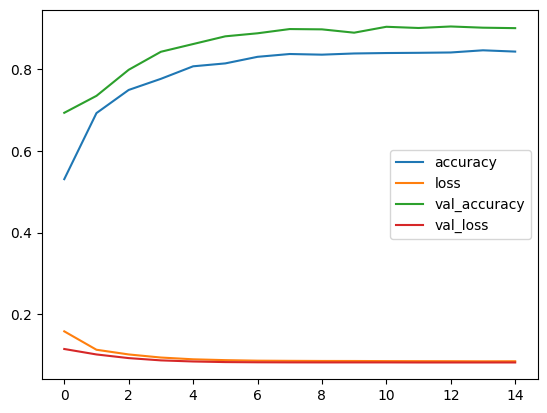

In [6]:
training_result.plot()

In [7]:
test_prediction = model.predict(x_test_noisy)

mse = tf.keras.losses.MeanSquaredError()

# Compute the MSE loss
mse_loss = mse(x_test_noisy, test_prediction).numpy()

# Output the MSE loss
print(f'Mean Squared Error Loss: {mse_loss}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Mean Squared Error Loss: 0.08060210943222046


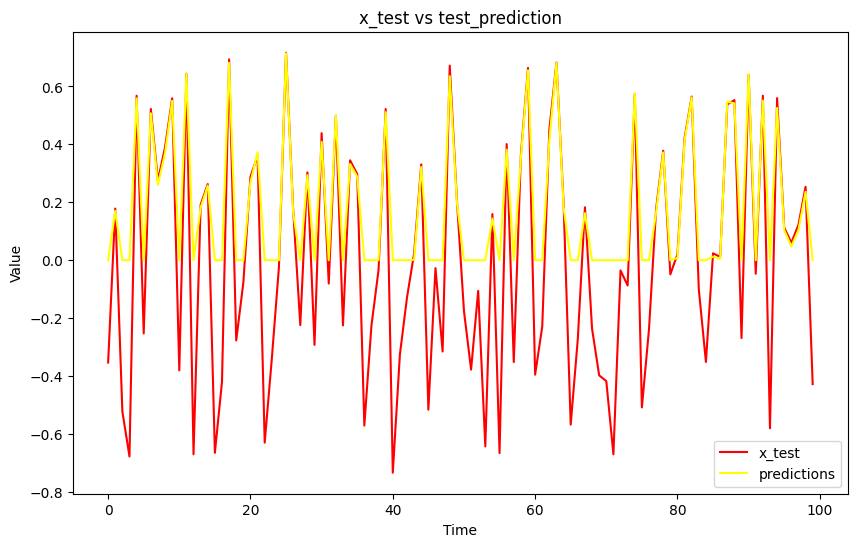

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(x_test_noisy[:100, 0], label='x_test', color='red')
plt.plot(test_prediction[:100, 0], label='predictions', color='yellow')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('x_test vs test_prediction')
plt.legend()
plt.show()